**CS 4501 - Digital Signal Processing**

Phyl Peng (hp9psb), Brian Mbogo (bpm4pkz), Anna Williamson (amw4uet)

*Image filter design for different noise distributions*

In [14]:
from scipy.fft import ifft2
from scipy import signal
from PIL import Image
from statistics import median
from numpy import asarray

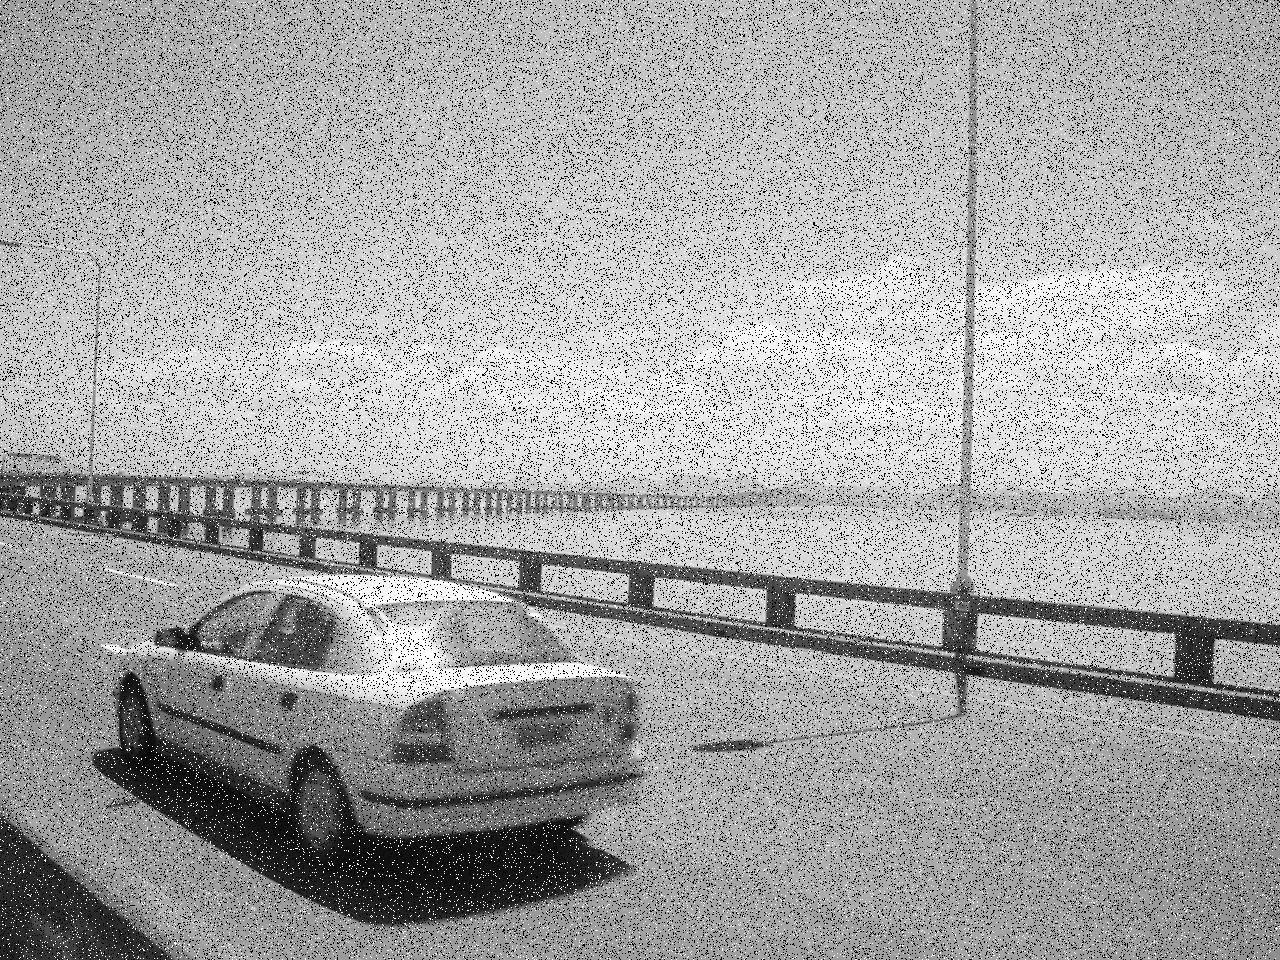

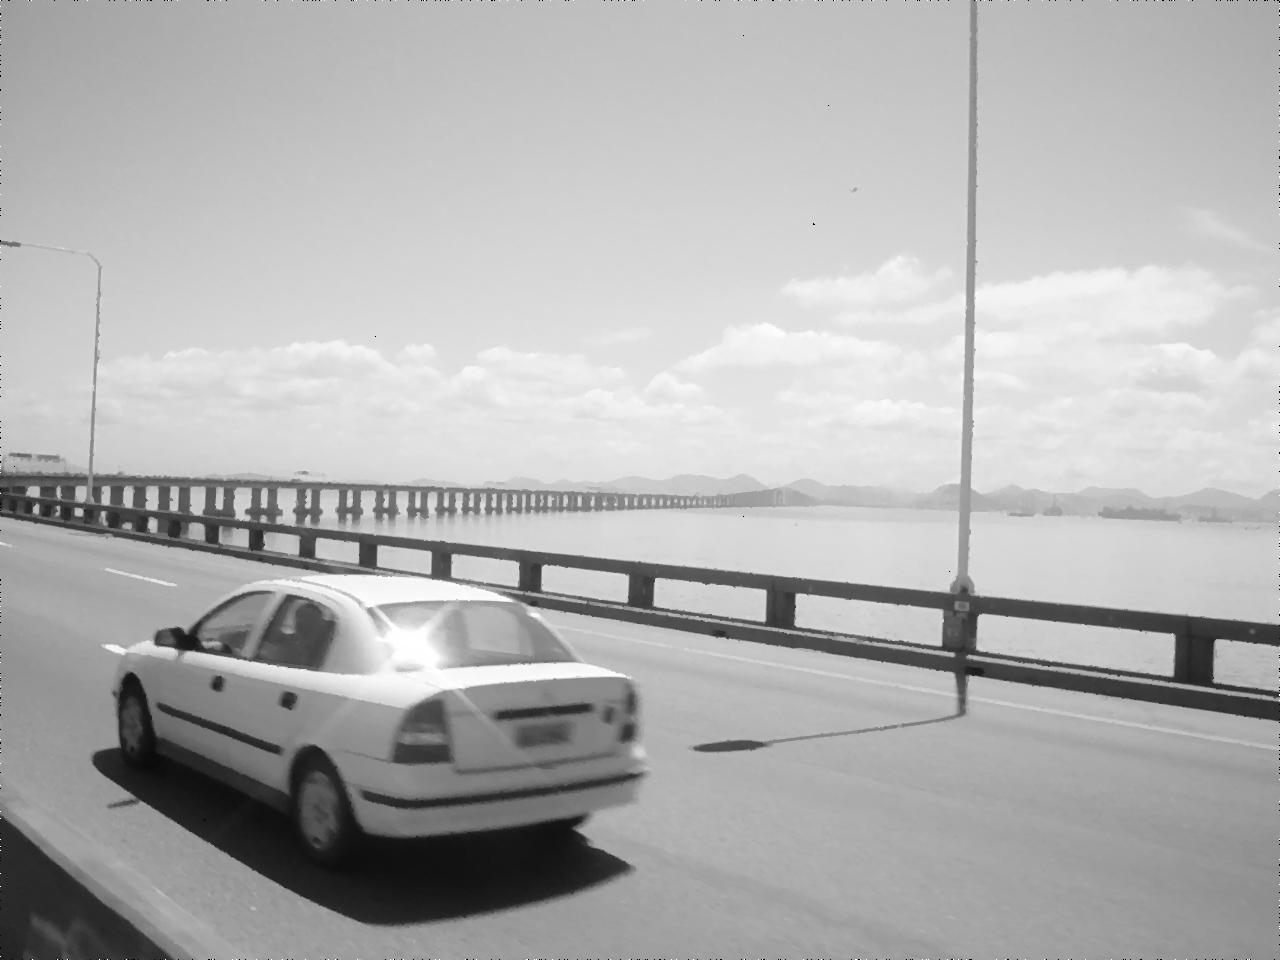

In [51]:
# Filter implementation to handle saltpepper noise

'''
SOURCES:

https://en.wikipedia.org/wiki/Salt-and-pepper_noise
https://www.cs.auckland.ac.nz/courss/compsci373s1c/PatricesLectures/Image%20Filtering.pdf
https://www.geeksforgeeks.org/python-pil-getpixel-method/
https://stackoverflow.com/questions/52307290/what-is-the-difference-between-images-in-p-and-l-mode-in-pil#:~:text=If%20you%20have%20an%20L,stores%20a%20greyscale%2C%20not%20colour.
https://ijesc.org/upload/a2d11768dad7f56db1cc12bb3650879a.A%20Comparison%20of%20Salt%20and%20Pepper%20Noise%20Removal%20Filters.pdf
'''

'''
NOTES:

- "An effective noise reduction method for this type of noise is a median filter or a morphological filter."
- first attempt: median filter
- note: images are in "L"-mode... maps to black and white pixels/greyscale
- a median filter is the best of a variety of filters to handle salt and pepper noise
'''


def median_pixel(width, height, w, h, px):
    if (w != 0 and w != width-1 and h != 0 and h != height-1): # don't compute the edges
        px[w, h] = median([px[w, h+1], px[w, h-1], px[w+1, h], px[w-1, h], px[w-1, h-1], px[w+1, h-1], px[w+1, h+1], px[w-1, h+1], px[w, h]])
    return


def median_filter(im):
    px = im.load()
    width, height = im.size
    for w in range(0, width):
        for h in range(0, height):
            median_pixel(width, height, w, h, px)
    return

 
# load image
im = Image.open(r"saltpepper_car.jpg")
display(im)

# filter image
median_filter(im)
display(im)


In [64]:
# laplacian filter?

'''
SOURCES:

https://www.youtube.com/watch?v=kewse-JsjH0
https://www.geeksforgeeks.org/laplacian-filter-using-matlab/
https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
https://www.l3harrisgeospatial.com/docs/laplacianfilters.html#:~:text=Laplacian%20filter%20kernels%20usually%20contain,be%20either%20negative%20or%20positive.
https://www.geeksforgeeks.org/image-sharpening-using-laplacian-filter-and-high-boost-filtering-in-matlab/
'''

def sharpen_edges(im, new_image, mult):
    data_im = asarray(im)
    data_newimage = asarray(new_image)
    sharp_image = Image.fromarray(abs(data_im + (mult)*data_newimage))
    return sharp_image

def apply_laplacian(im, kernal):
    px = im.load()
    data = asarray(im) # load image as a 2d array
    new = signal.convolve2d(data, kernel, boundary='symm', mode='same')
    new_image = Image.fromarray(abs(new))
    return new_image

# kernel = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
# new_image = apply_laplacian(im, kernel)
# new_image.show() # need to use show()! Using display() won't work here
# sharp_im = sharpen_edges(im, new_image, -1)
# sharp_im.show()

kernel = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
new_image = apply_laplacian(im, kernel)
new_image.show() # need to use show()! Using display() won't work here
sharp_im = sharpen_edges(im, new_image, 1)
sharp_im.show()

